In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import agama
import auriga_public as ap
from astropy.cosmology import Planck13 as cosmo

In [2]:
plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

agama.setUnits(length=1, velocity=1, mass=1)

figpath = 'figs/'

In [3]:
halo = 'halo_18'
directory = '/Users/adam/Auriga/level4/Original/halo_18/'

In [4]:
import glob
path = glob.glob(directory+'/*')
print('path',path)

path ['/Users/adam/Auriga/level4/Original/halo_18/snapdir_095', '/Users/adam/Auriga/level4/Original/halo_18/snapdir_061', '/Users/adam/Auriga/level4/Original/halo_18/snapdir_069', '/Users/adam/Auriga/level4/Original/halo_18/groups_053', '/Users/adam/Auriga/level4/Original/halo_18/snapdir_112', '/Users/adam/Auriga/level4/Original/halo_18/groups_127', '/Users/adam/Auriga/level4/Original/halo_18/groups_118', '/Users/adam/Auriga/level4/Original/halo_18/snapdir_106', '/Users/adam/Auriga/level4/Original/halo_18/groups_078', '/Users/adam/Auriga/level4/Original/halo_18/snapdir_087', '/Users/adam/Auriga/level4/Original/halo_18/groups_084', '/Users/adam/Auriga/level4/Original/halo_18/snapdir_081', '/Users/adam/Auriga/level4/Original/halo_18/snapdir_075', '/Users/adam/Auriga/level4/Original/halo_18/groups_069', '/Users/adam/Auriga/level4/Original/halo_18/snapdir_053', '/Users/adam/Auriga/level4/Original/halo_18/groups_061', '/Users/adam/Auriga/level4/Original/halo_18/groups_095', '/Users/adam/Aur

In [5]:
'''Functions to load data and calculate disc orientation'''

def load_data(snap_num, partType=4):
    if partType==4:
        attrstoload = ['Coordinates', 'Velocities', 'GFM_StellarFormationTime', 'GFM_InitialMass', 'Masses', 'ParticleIDs', 'Potential', 'GFM_Metallicity']
    
    else:
        attrstoload = ['Coordinates', 'Velocities', 'Masses', 'ParticleIDs', 'Potential']
    outputdir = directory 
    snapdir = 'snapdir_%03d/'%snap_num
    print(snapdir)
    snapobj = ap.snapshot.load_snapshot(snap_num, partType, loadlist=attrstoload, snappath=outputdir, verbose=False)

    '''Load subhalo position and virial radius'''
    subobj = ap.subhalos.subfind(snap_num, directory=outputdir, loadlist=['SubhaloPos', 'Group_R_Crit200', 'SubhaloMass'])

    """Centre the particles/cells on the most massive subhalo (the main galaxy)"""
    snapobj = ap.util.CentreOnHalo(snapobj, subobj.data['SubhaloPos'][0])

    """Remove bulk velocity"""
    bulk_velocity = ap.util.remove_bulk_velocity(snapobj, idx=None, radialcut=0.1*subobj.data['Group_R_Crit200'][0])

    if partType == 4:
        snapobj = ap.util.apply_mask(snapobj, stars=True, radialcut=subobj.data['Group_R_Crit200'][0])
    
    else:
        snapobj = ap.util.apply_mask(snapobj, radialcut=subobj.data['Group_R_Crit200'][0])

    return snapobj, subobj

def transform_data(snapobj, subobj, snapobj_star):

    star_radius = ap.util.r(snapobj_star)
    istars, = np.where( (star_radius < 0.05*subobj.data['Group_R_Crit200'][0]) )
    L = np.cross( snapobj_star.data['Coordinates'][istars,:], (snapobj_star.data['Velocities'][istars,:] * snapobj_star.data['Masses'][istars,None]) )
    Ltot = L.sum( axis=0 )
    Ldir = Ltot / np.sqrt( (Ltot**2).sum() )
    print('Calculated stellar angular momentum unit vector: ',Ldir)
    xdir, ydir, zdir = ap.util.get_principal_axis( snapobj_star, istars, L=Ldir )
    print('Found eigenvector of inertia tensor aligned closest to angular momentum unit vector of stars.')
    ap.util.rotateto(snapobj, xdir, dir2=ydir, dir3=zdir)

    # '''Rotate coordinates to align with disc'''
    # ap.util.align_galaxy( snapobj, idx=None, radialcut=0.1*subobj.data['Group_R_Crit200'][0] )

    return snapobj


def calc_disc_axis(snap_num):
    attrstoload = ['Coordinates', 'Velocities', 'GFM_StellarFormationTime', 'GFM_InitialMass', 'Masses', 'ParticleIDs', 'Potential', 'GFM_Metallicity']
    outputdir = directory 
    snapdir = 'snapdir_%03d/'%snap_num
    print(snapdir)
    snapobj = ap.snapshot.load_snapshot(snap_num, 4, loadlist=attrstoload, snappath=outputdir, verbose=False)

    '''Load subhalo position and virial radius'''
    subobj = ap.subhalos.subfind(snap_num, directory=outputdir, loadlist=['SubhaloPos', 'Group_R_Crit200'])

    """Centre the particles/cells on the most massive subhalo (the main galaxy)"""
    snapobj = ap.util.CentreOnHalo(snapobj, subobj.data['SubhaloPos'][0])

    """Remove bulk velocity"""
    bulk_velocity = ap.util.remove_bulk_velocity(snapobj, idx=None, radialcut=0.1*subobj.data['Group_R_Crit200'][0])

    snapobj = ap.util.apply_mask(snapobj, stars=True, radialcut=subobj.data['Group_R_Crit200'][0])

    Lz = snapobj.data['Masses'][:,None] * np.cross(snapobj.data['Coordinates'], snapobj.data['Velocities'])

    r = np.linalg.norm(snapobj.data['Coordinates'], axis=-1)

    Lz_tot = Lz[r < 0.05*subobj.data['Group_R_Crit200'][0]].sum(axis=0)

    zhat = Lz_tot / np.linalg.norm(Lz_tot, axis=-1)

    return zhat


In [6]:
'''Identify particles present in all snapshots'''

snap_list = [78, 81, 84, 87, 95, 106, 112, 118, 127]
snapobjlist = []
IDs_list = []
indices_list = []

zhat_array = np.zeros((len(snap_list),3))
redshift_array = np.zeros(len(snap_list))
tL_array = np.zeros(len(snap_list))

for i in range(len(snap_list)):
    snapobj_0, subobj = load_data(snap_list[i])
    snapobj = transform_data(snapobj_0, subobj, snapobj_0)
    snapobjlist.append(snapobj)
    IDs = snapobj.data['ParticleIDs']
    IDs_list.append(IDs)

    zhat = calc_disc_axis(snap_list[i])

    redshift = snapobj.header['Redshift']
    tL = cosmo.lookback_time(redshift)
    
    zhat_array[i] = zhat
    redshift_array[i] = redshift
    tL_array[i] = tL.value

Delta_theta = np.arccos((zhat_array[:-1]*zhat_array[1:]).sum(axis=-1)) * 180/np.pi
theta = np.arccos((zhat_array*zhat_array[-1]).sum(axis=-1)) * 180/np.pi

from functools import reduce
common_IDs = reduce(np.intersect1d, IDs_list)

for i in range(len(snap_list)):
    common_IDs, indices, _ = np.intersect1d(IDs_list[i], common_IDs, return_indices=True)
    print(common_IDs.shape)
    indices_list.append(indices)

# common_IDs, indexes0, indexes1 = np.intersect1d(IDs0, IDs1, return_indices=True)

# indexes_list = [indexes0, indexes1]


snapdir_078/
snappath= /Users/adam/Auriga/level4/Original/halo_18//snapdir_078/ /Users/adam/Auriga/level4/Original/halo_18//snapdir_078/snapshot_078 78
Loading multiple files.
Calculated stellar angular momentum unit vector:  [-0.74974084 -0.38684833  0.53687716]
Found eigenvector of inertia tensor aligned closest to angular momentum unit vector of stars.
snapdir_078/
snappath= /Users/adam/Auriga/level4/Original/halo_18//snapdir_078/ /Users/adam/Auriga/level4/Original/halo_18//snapdir_078/snapshot_078 78
Loading multiple files.
snapdir_081/
snappath= /Users/adam/Auriga/level4/Original/halo_18//snapdir_081/ /Users/adam/Auriga/level4/Original/halo_18//snapdir_081/snapshot_081 81
Loading multiple files.
Calculated stellar angular momentum unit vector:  [-0.7997164 -0.2891446  0.5261645]
Found eigenvector of inertia tensor aligned closest to angular momentum unit vector of stars.
snapdir_081/
snappath= /Users/adam/Auriga/level4/Original/halo_18//snapdir_081/ /Users/adam/Auriga/level4/Origi

/var/folders/z0/1zblnsv52b3_xm5q_770smk40000gn/T/ipykernel_45209/3836103901.py:29: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos((zhat_array*zhat_array[-1]).sum(axis=-1)) * 180/np.pi


(905666,)
(905666,)
(905666,)
(905666,)
(905666,)
(905666,)
(905666,)
(905666,)
(905666,)


In [7]:
from scipy.stats import binned_statistic, binned_statistic_2d

'''Load data'''

pos = np.zeros((len(snap_list), len(common_IDs), 3))
vel = np.zeros((len(snap_list), len(common_IDs), 3))
pot = np.zeros((len(snap_list), len(common_IDs)))

for i, snapobj in enumerate(snapobjlist):

    # Load positions, velocities, etc.
    pos[i] = np.flip(snapobj.data['Coordinates'][indices_list[i]] * 1e3, axis=-1)
    vel[i] = -np.flip(snapobj.data['Velocities'][indices_list[i]], axis=-1)
    pot[i] = snapobj.data['Potential'][indices_list[i]]

IDs = snapobjlist[0].data['ParticleIDs'][indices_list[0]]
MH = np.log10(snapobjlist[0].data['GFM_Metallicity'][indices_list[0]] / 0.0127)
ages = ap.util.GetLookbackTimeFromScaleFactor_Flat(snapobjlist[-1].data['GFM_StellarFormationTime'], snapobj.hubbleparam, snapobj.omega0, snapobj.omegalambda)[indices_list[-1]]

# Identify in situ stars
list_directory = '/Users/adam/Auriga/level4/Original/lists/accretedstardata/'
mdata = ap.util.read_starparticle_mergertree_data_hdf5(snap_list[0], list_directory, 'halo_18')
insitu_IDs = mdata['Insitu']['ParticleIDs']
insitu_flag = np.isin(IDs, insitu_IDs)

# Identify stars from each progenitor
first_prog = np.array(sorted(set(list(mdata['Exsitu']['PeakMassIndex']))))
print('first_prog=',first_prog,len(first_prog))
"""Count the number of star particles that are now bound to the main halo from each progenitor system, and sort in descending order of mass"""
nstars_in_subhalo = np.zeros(len(first_prog))
for i, pid in enumerate(first_prog):
    nstars_in_subhalo[i] = np.sum( (mdata['Exsitu']['PeakMassIndex']==pid) & (mdata['Exsitu']['AccretedFlag']==0))

print('finished finding stars for each progenitor.')
nsort = np.argsort(nstars_in_subhalo)[::-1]
nstars_in_subhalo = nstars_in_subhalo[nsort].astype('int')
first_prog = first_prog[nsort]
print('first_prog=',first_prog,len(first_prog))
print('nstars_in_subhalo=',nstars_in_subhalo)

# Calculate radii, angular momenta, energies
xv = np.concatenate((pos, vel), axis=-1)
r = ((pos**2).sum(axis=-1))**0.5
R = ((pos[:,:,:2]**2).sum(axis=-1))**0.5
z = pos[:,:,2]

L = np.cross(pos, vel)
Lz = L[:,:,2]
Lperp = (L[:,:,0]**2 + L[:,:,1]**2)**0.5
E = 0.5 * (vel**2).sum(axis=-1) + pot

vphi = Lz / R


/var/folders/z0/1zblnsv52b3_xm5q_770smk40000gn/T/ipykernel_45209/1353555490.py:17: RuntimeWarning: divide by zero encountered in log10
  MH = np.log10(snapobjlist[0].data['GFM_Metallicity'][indices_list[0]] / 0.0127)
/var/folders/z0/1zblnsv52b3_xm5q_770smk40000gn/T/ipykernel_45209/1353555490.py:17: RuntimeWarning: invalid value encountered in log10
  MH = np.log10(snapobjlist[0].data['GFM_Metallicity'][indices_list[0]] / 0.0127)


824820 in-situ and 546870 ex-situ stars found
first_prog= [    -1    125    130    171    176    185    190    205    244    263
    464    473    951   1233   1237   1633   1639   2612   2776   3393
   3828   8241   9017   9161   9234   9437   9534  11230  12653  14029
  14805  19304  20838  22056  22280  22432  23819  24191  26659  27794
  27805  28130  28392  30421  31277  34235  34316  36552  46531  47517
  50762  51520  53344  53608  57810  60574  62771  63678  63853  64027
  64090  64104  64220  64418  64574  64663  64734  64838  64873  64939
  66681  66945  67034  67157  67243  69991  71274  75966  83913  91458
 113165 113413 113686 122851 123180 126660 128014 128036 128255 128278
 128331 128338 128390 128397 128408 128517 128694 128737 128803 128811
 128914 129173 130337 130413 130515 130806 131020 131080 131082 131192
 131852 132210 132540 132995 148234 161006 161410 161876 161957 161979
 162106 163527 164993 168041 172149 172429 172644 175852 181766 181913
 183048 183745 1865

/var/folders/z0/1zblnsv52b3_xm5q_770smk40000gn/T/ipykernel_45209/1353555490.py:52: RuntimeWarning: invalid value encountered in divide
  vphi = Lz / R


snapdir_078/
snappath= /Users/adam/Auriga/level4/Original/halo_18//snapdir_078/ /Users/adam/Auriga/level4/Original/halo_18//snapdir_078/snapshot_078 78
Loading multiple files.
Calculated stellar angular momentum unit vector:  [-0.74974084 -0.38684833  0.53687716]
Found eigenvector of inertia tensor aligned closest to angular momentum unit vector of stars.
snapdir_078/
snappath= /Users/adam/Auriga/level4/Original/halo_18//snapdir_078/ /Users/adam/Auriga/level4/Original/halo_18//snapdir_078/snapshot_078 78
Loading multiple files.
snapdir_078/
snappath= /Users/adam/Auriga/level4/Original/halo_18//snapdir_078/ /Users/adam/Auriga/level4/Original/halo_18//snapdir_078/snapshot_078 78
Loading multiple files.
Calculated stellar angular momentum unit vector:  [-0.74974084 -0.38684833  0.53687716]
Found eigenvector of inertia tensor aligned closest to angular momentum unit vector of stars.
snapdir_078/
snappath= /Users/adam/Auriga/level4/Original/halo_18//snapdir_078/ /Users/adam/Auriga/level4/Or

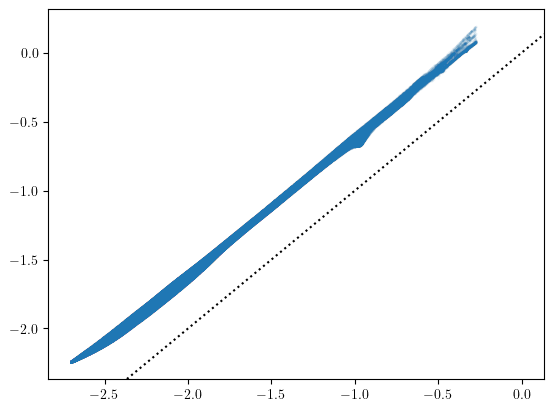

snapdir_081/
snappath= /Users/adam/Auriga/level4/Original/halo_18//snapdir_081/ /Users/adam/Auriga/level4/Original/halo_18//snapdir_081/snapshot_081 81
Loading multiple files.
Calculated stellar angular momentum unit vector:  [-0.7997164 -0.2891446  0.5261645]
Found eigenvector of inertia tensor aligned closest to angular momentum unit vector of stars.
snapdir_081/
snappath= /Users/adam/Auriga/level4/Original/halo_18//snapdir_081/ /Users/adam/Auriga/level4/Original/halo_18//snapdir_081/snapshot_081 81
Loading multiple files.
snapdir_081/
snappath= /Users/adam/Auriga/level4/Original/halo_18//snapdir_081/ /Users/adam/Auriga/level4/Original/halo_18//snapdir_081/snapshot_081 81
Loading multiple files.
Calculated stellar angular momentum unit vector:  [-0.7997164 -0.2891446  0.5261645]
Found eigenvector of inertia tensor aligned closest to angular momentum unit vector of stars.
snapdir_081/
snappath= /Users/adam/Auriga/level4/Original/halo_18//snapdir_081/ /Users/adam/Auriga/level4/Original

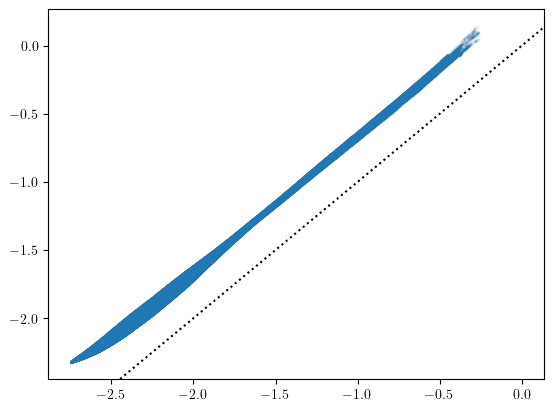

snapdir_084/
snappath= /Users/adam/Auriga/level4/Original/halo_18//snapdir_084/ /Users/adam/Auriga/level4/Original/halo_18//snapdir_084/snapshot_084 84
Loading multiple files.
Calculated stellar angular momentum unit vector:  [-0.7768836  -0.07422845  0.6252535 ]
Found eigenvector of inertia tensor aligned closest to angular momentum unit vector of stars.
snapdir_084/
snappath= /Users/adam/Auriga/level4/Original/halo_18//snapdir_084/ /Users/adam/Auriga/level4/Original/halo_18//snapdir_084/snapshot_084 84
Loading multiple files.
snapdir_084/
snappath= /Users/adam/Auriga/level4/Original/halo_18//snapdir_084/ /Users/adam/Auriga/level4/Original/halo_18//snapdir_084/snapshot_084 84
Loading multiple files.
Calculated stellar angular momentum unit vector:  [-0.7768836  -0.07422845  0.6252535 ]
Found eigenvector of inertia tensor aligned closest to angular momentum unit vector of stars.
snapdir_084/
snappath= /Users/adam/Auriga/level4/Original/halo_18//snapdir_084/ /Users/adam/Auriga/level4/Or

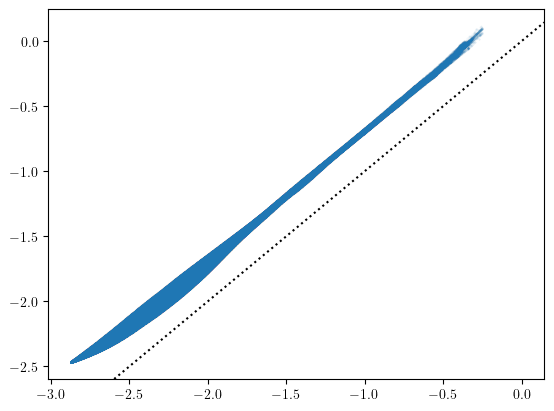

snapdir_087/
snappath= /Users/adam/Auriga/level4/Original/halo_18//snapdir_087/ /Users/adam/Auriga/level4/Original/halo_18//snapdir_087/snapshot_087 87
Loading multiple files.
Calculated stellar angular momentum unit vector:  [-0.7391882  -0.04765234  0.67181104]
Found eigenvector of inertia tensor aligned closest to angular momentum unit vector of stars.
snapdir_087/
snappath= /Users/adam/Auriga/level4/Original/halo_18//snapdir_087/ /Users/adam/Auriga/level4/Original/halo_18//snapdir_087/snapshot_087 87
Loading multiple files.
snapdir_087/
snappath= /Users/adam/Auriga/level4/Original/halo_18//snapdir_087/ /Users/adam/Auriga/level4/Original/halo_18//snapdir_087/snapshot_087 87
Loading multiple files.
Calculated stellar angular momentum unit vector:  [-0.7391882  -0.04765234  0.67181104]
Found eigenvector of inertia tensor aligned closest to angular momentum unit vector of stars.
snapdir_087/
snappath= /Users/adam/Auriga/level4/Original/halo_18//snapdir_087/ /Users/adam/Auriga/level4/Or

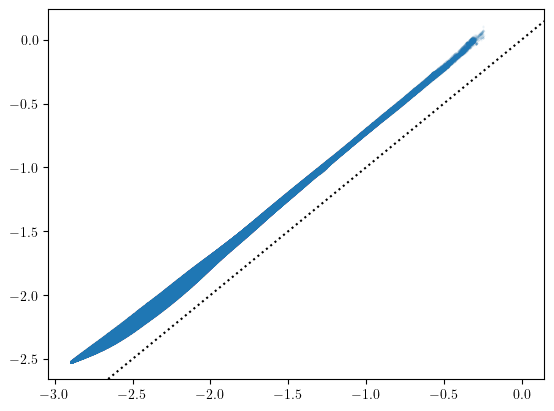

snapdir_095/
snappath= /Users/adam/Auriga/level4/Original/halo_18//snapdir_095/ /Users/adam/Auriga/level4/Original/halo_18//snapdir_095/snapshot_095 95
Loading multiple files.
Calculated stellar angular momentum unit vector:  [-0.58610237 -0.03311422  0.80956   ]
Found eigenvector of inertia tensor aligned closest to angular momentum unit vector of stars.
snapdir_095/
snappath= /Users/adam/Auriga/level4/Original/halo_18//snapdir_095/ /Users/adam/Auriga/level4/Original/halo_18//snapdir_095/snapshot_095 95
Loading multiple files.
snapdir_095/
snappath= /Users/adam/Auriga/level4/Original/halo_18//snapdir_095/ /Users/adam/Auriga/level4/Original/halo_18//snapdir_095/snapshot_095 95
Loading multiple files.
Calculated stellar angular momentum unit vector:  [-0.58610237 -0.03311422  0.80956   ]
Found eigenvector of inertia tensor aligned closest to angular momentum unit vector of stars.
snapdir_095/
snappath= /Users/adam/Auriga/level4/Original/halo_18//snapdir_095/ /Users/adam/Auriga/level4/Or

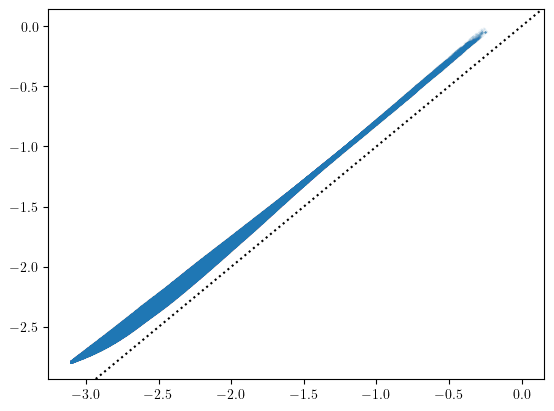

snapdir_106/
snappath= /Users/adam/Auriga/level4/Original/halo_18//snapdir_106/ /Users/adam/Auriga/level4/Original/halo_18//snapdir_106/snapshot_106 106
Loading multiple files.
Calculated stellar angular momentum unit vector:  [-0.6001464  -0.01281208  0.7997875 ]
Found eigenvector of inertia tensor aligned closest to angular momentum unit vector of stars.
snapdir_106/
snappath= /Users/adam/Auriga/level4/Original/halo_18//snapdir_106/ /Users/adam/Auriga/level4/Original/halo_18//snapdir_106/snapshot_106 106
Loading multiple files.
snapdir_106/
snappath= /Users/adam/Auriga/level4/Original/halo_18//snapdir_106/ /Users/adam/Auriga/level4/Original/halo_18//snapdir_106/snapshot_106 106
Loading multiple files.
Calculated stellar angular momentum unit vector:  [-0.6001464  -0.01281208  0.7997875 ]
Found eigenvector of inertia tensor aligned closest to angular momentum unit vector of stars.
snapdir_106/
snappath= /Users/adam/Auriga/level4/Original/halo_18//snapdir_106/ /Users/adam/Auriga/level4

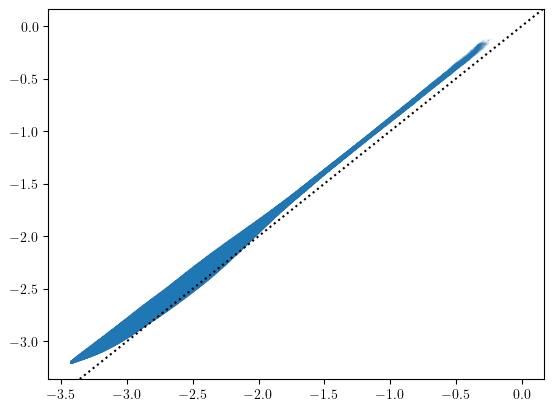

snapdir_112/
snappath= /Users/adam/Auriga/level4/Original/halo_18//snapdir_112/ /Users/adam/Auriga/level4/Original/halo_18//snapdir_112/snapshot_112 112
Loading multiple files.
Calculated stellar angular momentum unit vector:  [-0.60023004 -0.03728121  0.798958  ]
Found eigenvector of inertia tensor aligned closest to angular momentum unit vector of stars.
snapdir_112/
snappath= /Users/adam/Auriga/level4/Original/halo_18//snapdir_112/ /Users/adam/Auriga/level4/Original/halo_18//snapdir_112/snapshot_112 112
Loading multiple files.
snapdir_112/
snappath= /Users/adam/Auriga/level4/Original/halo_18//snapdir_112/ /Users/adam/Auriga/level4/Original/halo_18//snapdir_112/snapshot_112 112
Loading multiple files.
Calculated stellar angular momentum unit vector:  [-0.60023004 -0.03728121  0.798958  ]
Found eigenvector of inertia tensor aligned closest to angular momentum unit vector of stars.
snapdir_112/
snappath= /Users/adam/Auriga/level4/Original/halo_18//snapdir_112/ /Users/adam/Auriga/level4

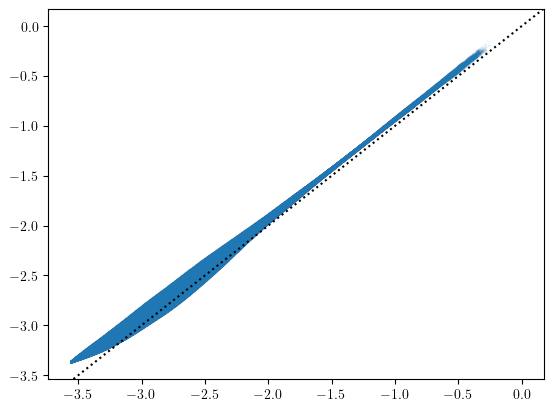

snapdir_118/
snappath= /Users/adam/Auriga/level4/Original/halo_18//snapdir_118/ /Users/adam/Auriga/level4/Original/halo_18//snapdir_118/snapshot_118 118
Loading multiple files.
Calculated stellar angular momentum unit vector:  [-0.54952407 -0.05455932  0.8336945 ]
Found eigenvector of inertia tensor aligned closest to angular momentum unit vector of stars.
snapdir_118/
snappath= /Users/adam/Auriga/level4/Original/halo_18//snapdir_118/ /Users/adam/Auriga/level4/Original/halo_18//snapdir_118/snapshot_118 118
Loading multiple files.
snapdir_118/
snappath= /Users/adam/Auriga/level4/Original/halo_18//snapdir_118/ /Users/adam/Auriga/level4/Original/halo_18//snapdir_118/snapshot_118 118
Loading multiple files.
Calculated stellar angular momentum unit vector:  [-0.54952407 -0.05455932  0.8336945 ]
Found eigenvector of inertia tensor aligned closest to angular momentum unit vector of stars.
snapdir_118/
snappath= /Users/adam/Auriga/level4/Original/halo_18//snapdir_118/ /Users/adam/Auriga/level4

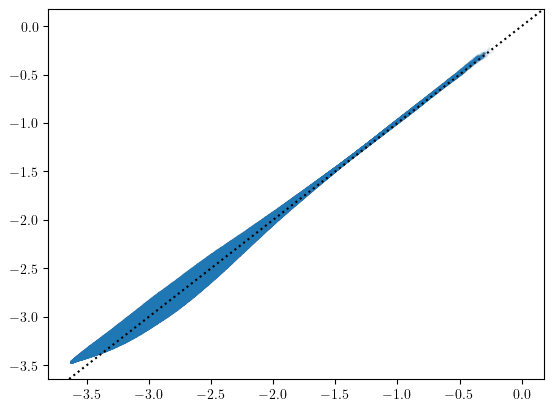

snapdir_127/
snappath= /Users/adam/Auriga/level4/Original/halo_18//snapdir_127/ /Users/adam/Auriga/level4/Original/halo_18//snapdir_127/snapshot_127 127
Loading multiple files.
Calculated stellar angular momentum unit vector:  [-0.50016016 -0.12215855  0.8572731 ]
Found eigenvector of inertia tensor aligned closest to angular momentum unit vector of stars.
snapdir_127/
snappath= /Users/adam/Auriga/level4/Original/halo_18//snapdir_127/ /Users/adam/Auriga/level4/Original/halo_18//snapdir_127/snapshot_127 127
Loading multiple files.
snapdir_127/
snappath= /Users/adam/Auriga/level4/Original/halo_18//snapdir_127/ /Users/adam/Auriga/level4/Original/halo_18//snapdir_127/snapshot_127 127
Loading multiple files.
Calculated stellar angular momentum unit vector:  [-0.50016016 -0.12215855  0.8572731 ]
Found eigenvector of inertia tensor aligned closest to angular momentum unit vector of stars.
snapdir_127/
snappath= /Users/adam/Auriga/level4/Original/halo_18//snapdir_127/ /Users/adam/Auriga/level4

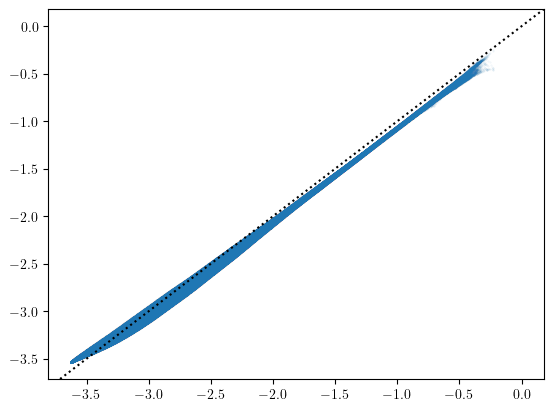

In [8]:
'''Calculate axisymmetrised potential using agama'''

import agama
from scipy.stats import binned_statistic_2d
from scipy.interpolate import RegularGridInterpolator

Rbins = np.linspace(0, 40, 41)
zbins = np.linspace(-40, 40, 41)

Rc = 0.5*(Rbins[1:] + Rbins[:-1])
zc = 0.5*(zbins[1:] + zbins[:-1])

act = np.zeros(pos.shape)
ang = np.zeros(pos.shape)
freq = np.zeros(pos.shape)
pot_agama = np.zeros(len(snap_list), dtype=object)
pot_agama_axi = np.zeros(len(snap_list), dtype=object)

for i in range(len(snap_list)):

    snapobj_star_0, subobj = load_data(snap_list[i], partType=4)
    snapobj_star = transform_data(snapobj_star_0, subobj, snapobj_star_0)
    pos_star = np.flip(snapobj_star.data['Coordinates'] * 1e3, axis=-1)
    mass_star = snapobj_star.data['Masses'] * 1e10

    snapobj_star_0, subobj = load_data(snap_list[i], partType=4)
    snapobj_DM, subobj = load_data(snap_list[i], partType=1)
    snapobj_DM = transform_data(snapobj_DM, subobj, snapobj_star_0)
    pos_DM = np.flip(snapobj_DM.data['Coordinates'] * 1e3, axis=-1)
    mass_DM = snapobj_DM.data['Masses'] * 1e10
    # pot_DM = snapobj_DM.data['Potential']

    snapobj_star_0, subobj = load_data(snap_list[i], partType=4)
    snapobj_gas, subobj = load_data(snap_list[i], partType=0)
    snapobj_gas = transform_data(snapobj_gas, subobj, snapobj_star_0)
    pos_gas = np.flip(snapobj_gas.data['Coordinates'] * 1e3, axis=-1)
    mass_gas = snapobj_gas.data['Masses'] * 1e10

    print(subobj.data['SubhaloMass'][0])

    pot_DM = agama.Potential(type='Multipole', particles=(pos_DM, mass_DM), symmetry='a', gridsizeR=20, Rmin=0.2, Rmax=200, lmax=2)

    r_star = np.linalg.norm(pos_star, axis=-1)
    cut_disc = r_star > 2
    cut_bulge = ~cut_disc * (r_star > 0)
    pot_disc = agama.Potential(type='CylSpline', particles=(pos_star[cut_disc], mass_star[cut_disc]), gridSizeR=30, gridSizez=25, Rmin=1, Rmax=50, zmin=0.05, zmax=20, symmetry='a')
    pot_bulge = agama.Potential(type='Multipole', particles=(pos_star[cut_bulge], mass_star[cut_bulge]), gridsizeR=20, Rmin=0.1, Rmax=20, lmax=2, symmetry='a')

    pot_gas = agama.Potential(type='CylSpline', particles=(pos_gas, mass_gas), gridSizeR=30, gridSizez=25, Rmin=0.1, Rmax=50, zmin=0.05, zmax=20, symmetry='a')

    pot_agama[i] = agama.Potential(pot_DM, pot_disc, pot_bulge, pot_gas)


    rgrid = np.linspace(0, 10, 1001)
    # vcirc_squared = (-rgrid * pot_star.force(np.array([rgrid, 0*rgrid, 0*rgrid]).T)[:,0])
    Menc = pot_bulge.enclosedMass(rgrid)

    rstar = np.linalg.norm(pos_star, axis=-1)

    # plt.hist(rstar, bins=np.linspace(0, 5, 101))

    # Calculate actions
    af = agama.ActionFinder(pot_agama[i])
    act[i], ang[i], freq[i] = af(xv[i], angles=True)

    # # Plot estimated potentials vs catalogue values for validation
    cut = r[-1] > 0
    pot_test = pot_agama[i].potential(pos[i])

    plt.scatter(pot_test[cut]/1e5, pot[i,cut]/1e5, s=0.1, alpha=0.1)
    plt.axline((0,0), slope=1, c='k', ls=':')

    plt.show()
    plt.close()


In [9]:
'''Adjust potential values to match computed potential'''

for i in range(len(snap_list)):
    cut = (r[i] > 5)*(r[i] < 15)
    E_correction = np.median(pot_agama[i].potential(pos[i,cut]) - pot[i,cut])

    # pot[i] += E_correction
    # E[i] = 0.5 * (vel[i]**2).sum(axis=-1) + pot_agama[i].potential(pos[i])
    E[i] += E_correction
    # print(E_correction/1e5)

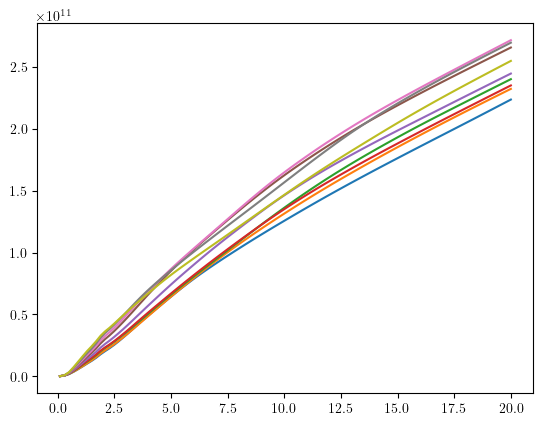

In [10]:
'''Calculate rotation curve'''

rgrid = np.linspace(0.1, 20, 101)

Menc_array = np.zeros((len(snap_list), len(rgrid)))

for i in range(len(snap_list)):
    vcirc = (-rgrid * pot_agama[i].force(np.array([rgrid, rgrid*0, rgrid*0]).T)[:,0])**0.5

    Menc = pot_agama[i].enclosedMass(rgrid)

    Menc_array[i] = Menc

    plt.plot(rgrid, Menc)


plt.show()
plt.close()


In [11]:
'''Calculate bar pattern speed using Dehnen+2023, and corotation'''

from patternSpeed import FourierMethod

Omegab_array = np.zeros(len(snap_list))

R_CR_array = np.zeros(len(snap_list))
R_OLR_array = np.zeros(len(snap_list))
R_11_array = np.zeros(len(snap_list))

rgrid = np.linspace(1, 20, 1001)

for i in range(len(snap_list)):
    Omegab = FourierMethod.patternSpeed(pos[i,:,0], pos[i,:,1], vel[i,:,0], vel[i,:,1])[0]['Om']

    Omegab_array[i] = Omegab

    vcirc = (-rgrid * pot_agama[i].force(np.array([rgrid, rgrid*0, rgrid*0]).T)[:,0])**0.5
    Omega_circ = vcirc / rgrid

    R_CR = rgrid[np.argmin(abs(Omega_circ - Omegab))]

    R_CR_array[i] = R_CR

    acc, der = pot_agama[i].forceDeriv(np.array([rgrid, rgrid*0, rgrid*0]).T) # ⇒ N × 3 and N × 6 arrays
    kappa = np.sqrt(-der[:,0] - 3*acc[:,0]/rgrid)

    # plt.plot(rgrid, Omega_circ + kappa/2)

    R_OLR = rgrid[np.argmin(abs(Omega_circ - Omegab + kappa/2))]
    R_OLR_array[i] = R_OLR

    R_11 = rgrid[np.argmin(abs(Omega_circ - Omegab + kappa))]
    R_11_array[i] = R_11

    # plt.axhline(Omegab)


print(R_OLR_array)


/Users/adam/projects/bar_streams/patternSpeed.py:335: RuntimeWarning: invalid value encountered in divide
  dPh = (X*Vy-Y*Vx)/Rq
/Users/adam/projects/bar_streams/patternSpeed.py:345: RuntimeWarning: invalid value encountered in divide
  self.Cph = X[i]/R
/Users/adam/projects/bar_streams/patternSpeed.py:346: RuntimeWarning: invalid value encountered in divide
  self.Sph = Y[i]/R
/Users/adam/projects/bar_streams/patternSpeed.py:187: RuntimeWarning: invalid value encountered in cast
  return phi.astype(np.intp)
/Users/adam/projects/bar_streams/patternSpeed.py:335: RuntimeWarning: invalid value encountered in divide
  dPh = (X*Vy-Y*Vx)/Rq
/Users/adam/projects/bar_streams/patternSpeed.py:345: RuntimeWarning: invalid value encountered in divide
  self.Cph = X[i]/R
/Users/adam/projects/bar_streams/patternSpeed.py:346: RuntimeWarning: invalid value encountered in divide
  self.Sph = Y[i]/R
/Users/adam/projects/bar_streams/patternSpeed.py:187: RuntimeWarning: invalid value encountered in cast
 

[12.571 14.566 13.673 12.666 12.096 11.659 11.678 11.469 11.488]


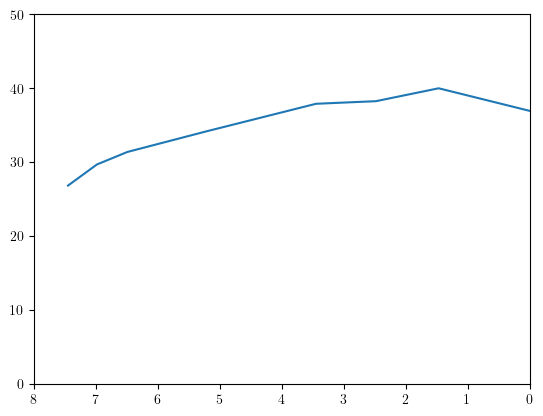

In [12]:
'''Plot pattern speed vs time'''

plt.plot(tL_array[1:], Omegab_array[1:])

plt.ylim(0,50)
plt.xlim(8,0)

plt.show()
plt.close()

In [13]:
'''Select groups of stars with similar energy/angular momenta at early times as mock GCs'''

np.random.seed(0)

# Cut from which to select mock clusters
cut = (ages>12)#*(r[-1]>2)

# Number of mock clusters
Nbody = 200

# Randomly select mock clusters from cut list of stars
index_prog_array = np.random.choice(np.where(cut)[0], Nbody, replace=False)

# snap_plot_indices = np.linspace(0, 8, 5).astype(int)
snap_strip_indices = np.arange(0, len(snap_list)-1)

cut_blob = np.zeros((len(snap_list), Nbody, len(E[0]))).astype(bool)
strip_flag = np.zeros((len(snap_list), Nbody, len(E[0]))).astype(bool)

for j in range(Nbody):
    index_prog = index_prog_array[j]

    dL = L - L[:,index_prog][:,None,:]
    dL_mag = np.linalg.norm(dL, axis=-1)

    dLz = dL[:,:,2]
    dLperp = Lperp - Lperp[:,index_prog][:,None]#(dL[:,:,0]**2 + dL[:,:,1]**2)**0.5
    dE = E - E[:,index_prog][:,None]

    dJ_mag = dLz**2 + dLperp**2 + (dE/Omegab_array[-1])**2

    # dJ = act - act[:,index_prog][:,None,:]
    # dJ_mag = np.linalg.norm(dJ, axis=-1)

    # In each snapshot, identify closest particles in action space and add them to the set of `stripped' stars
    for i in range(len(snap_list)):
        dJ_mag_argsort = np.argsort(dJ_mag[i])

        if np.isin(i, snap_strip_indices):
            cut_blob[i:,j,dJ_mag_argsort[:50]] = True
            strip_flag[i,j,dJ_mag_argsort[:50]] = True



<>:61: SyntaxWarning: invalid escape sequence '\m'
<>:61: SyntaxWarning: invalid escape sequence '\m'
/var/folders/z0/1zblnsv52b3_xm5q_770smk40000gn/T/ipykernel_45209/2641019837.py:61: SyntaxWarning: invalid escape sequence '\m'
  axs[0][i].set_title('$t_\mathrm{L}=$ '+str(np.round(tL_array[snap_plot_indices[i]],1))+' Gyr', fontsize=16)


0
1
2
3
4
0
1
2
3
0
1
2
0
1


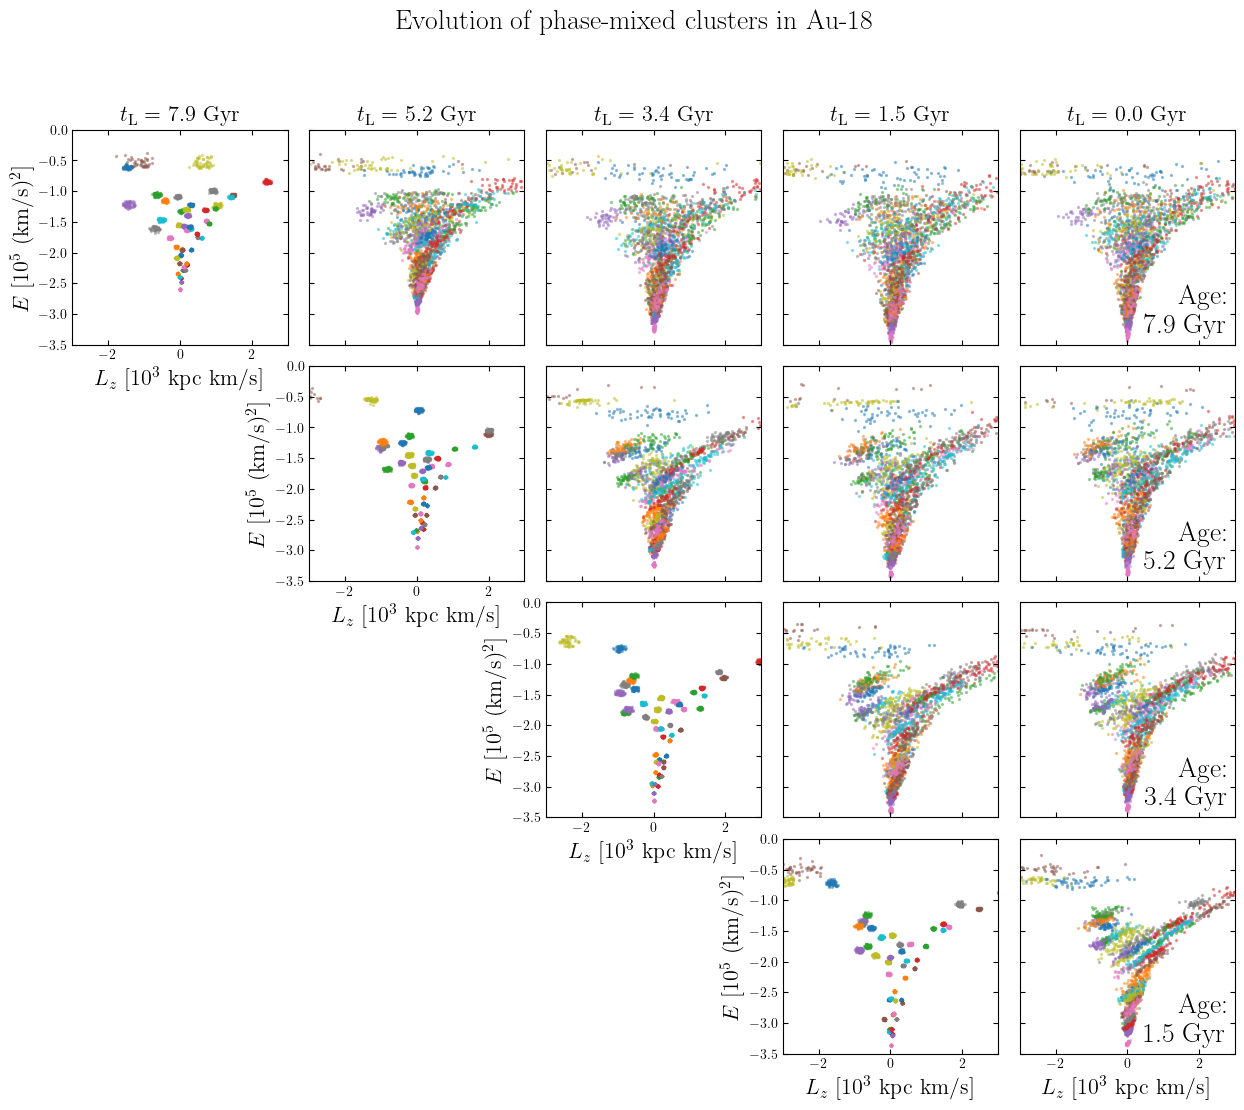

In [14]:
'''Plot results in (Lz, E) space'''
import matplotlib.gridspec as gridspec

HJ = E - Omegab_array[:,None] * Lz

cut = (ages>12)

snap_plot_indices = np.array([0, 4, 5, 7, 8])#np.linspace(0, 8, 5).astype(int)
rows = len(snap_plot_indices)-1
cols = len(snap_plot_indices)
figsize=(3*len(snap_plot_indices),3*(len(snap_plot_indices)-1))

fig = plt.figure(figsize=figsize)
gs = gridspec.GridSpec(rows,cols)

# fig, axs = plt.subplots(len(snap_plot_indices)-1,len(snap_plot_indices), figsize=(3*len(snap_plot_indices),3*(len(snap_plot_indices)-1)), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.1, hspace=0.1)

Lz_bins = np.linspace(-3, 3, 101)
Jz_bins = np.linspace(0, 1500, 101)



axs = []
ref_ax = None  # Will be set to the top-right subplot

for i in range(rows):
    num_cols = cols - i
    row_axes = []
    for j in range(num_cols):
        print(j)
        col_index = j + i  # Right-aligned
        if ref_ax is None:
            ax = fig.add_subplot(gs[i, col_index])
            ref_ax = ax  # First subplot becomes the reference
        else:
            ax = fig.add_subplot(gs[i, col_index], sharex=ref_ax, sharey=ref_ax)

        # Hide tick labels unless on left edge or bottom row
        if j != 0:
            ax.tick_params(labelleft=False)
        if j != 0 and i != rows-1:
            ax.tick_params(labelbottom=False)
        
        ax.set_xlim(-3, 3)
        ax.set_ylim(-3.5, 0)
        ax.tick_params(top=True, bottom=True, right=True, left=True, direction='in')
        ax.set_rasterization_zorder(10)
        
        row_axes.append(ax)
    axs.append(row_axes)




for i in range(len(snap_plot_indices)):
    Emin = np.nanmin(E[snap_plot_indices[i]]/1e5)
    # axs[0,i].hist2d(act[snap_plot_indices[i],cut,2], E[snap_plot_indices[i],cut]/1e5, bins=[Lz_bins, np.linspace(Emin, 0, 101)], norm=mcolors.LogNorm(), cmap='Greys', alpha=0.5)
    # axs[1,i].hist2d(act[snap_plot_indices[i],cut,2], HJ[snap_plot_indices[i],cut]/1e5, bins=[Lz_bins, np.linspace(Emin, 0, 101)], norm=mcolors.LogNorm(), cmap='Greys', alpha=0.5)

    axs[0][i].set_title('$t_\mathrm{L}=$ '+str(np.round(tL_array[snap_plot_indices[i]],1))+' Gyr', fontsize=16)
    # axs[-1][i].set_xlabel('$L_z$ [$10^3$ kpc km/s]', fontsize=16)
    # axs[1,i].set_xlabel('$L_z$ [kpc km/s]', fontsize=16)

    # Calculate energy of circular planar orbits
    rgrid = np.linspace(0.1, 40, 1000)
    vcirc = (-rgrid * pot_agama[snap_plot_indices[i]].force(np.array([rgrid, 0*rgrid, 0*rgrid]).T)[:,0])**0.5
    Lz_circ = rgrid * vcirc
    E_circ = 0.5 * vcirc**2 + pot_agama[snap_plot_indices[i]].potential(np.array([rgrid, 0*rgrid, 0*rgrid]).T)

    # for j in range(np.minimum(i+1, len(snap_plot_indices)-1)):
    #     axs[j,i].plot(Lz_circ/1e3, E_circ/1e5, c='grey', zorder=3)
    #     axs[j,i].plot(-Lz_circ/1e3, E_circ/1e5, c='grey', zorder=3)

for i in range(len(snap_plot_indices)-1):
    axs[i][0].set_xlabel('$L_z$ [$10^3$ kpc km/s]', fontsize=16)
    axs[i][0].set_ylabel('$E$ [$10^5$ (km/s)$^2$]', fontsize=16)
    axs[i][-1].text(2.8, -3.4, 'Age:\n'+str(np.round(tL_array[snap_plot_indices[i]],1))+' Gyr', fontsize=20, ha='right', va='bottom')
# axs[1,0].set_ylabel('$H_\mathrm{J}$ [$10^5$ (km/s)$^2$]', fontsize=16)

axs[-1][-1].set_xlabel('$L_z$ [$10^3$ kpc km/s]', fontsize=16)

Nplot = 50#Nbody

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for j in range(Nplot):
    for i in range(len(snap_list)):
        if np.isin(i, snap_plot_indices):
            for k in range(len(snap_plot_indices)-1):
                plot_index = np.where(snap_plot_indices == i)[0][0]
                cut_plot = cut_blob[i,j] * strip_flag[snap_plot_indices[k],j]

                if plot_index>=k:
                    axs[k][plot_index-k].scatter(Lz[i,cut_plot]/1e3, E[i,cut_plot]/1e5, s=2, alpha=0.4, c=colors[j%10])

            # plot_index = np.where(snap_plot_indices == i)[0][0]
            # cut_plot = cut_blob[i,j] * strip_flag[5,j] 
            # axs[1,plot_index].scatter(act[i,cut_plot,2], E[i,cut_plot]/1e5, s=1, alpha=0.4, c=colors[j%10])
            # axs[1,plot_index].scatter(act[i,cut_plot,2], HJ[i,cut_plot]/1e5, s=1, alpha=0.5, c=colors[j%10])
            
            # hist, xedges, yedges = np.histogram2d(act[i,cut_plot,2], E[i,cut_plot]/1e5, bins=[Lz_bins, np.linspace(Emin, 0, 101)])
            # hist = gaussian_filter(hist, sigma=2)
            # xc = 0.5*(xedges[1:] + xedges[:-1])
            # yc = 0.5*(yedges[1:] + yedges[:-1])
            # X, Y = np.meshgrid(xc, yc)

            # level = 0.4*np.max(hist)#np.percentile(hist[hist > 0], 60)
            # axs[plot_index].contour(X, Y, hist.T, levels=[level], colors=colors[j%10])


# for ax in axs.flat:
#     ax.set_xlim(-3, 3)
#     ax.set_ylim(-3.5, 0)
#     ax.tick_params(top=True, bottom=True, right=True, left=True, direction='in')
#     ax.set_rasterization_zorder(10)

fig.suptitle('Evolution of phase-mixed clusters in Au-18', fontsize=20)

plt.savefig(figpath+'auriga_E_Lz.pdf', bbox_inches='tight', dpi=200)
plt.show()
plt.close()

<>:35: SyntaxWarning: invalid escape sequence '\e'
<>:61: SyntaxWarning: invalid escape sequence '\O'
<>:67: SyntaxWarning: invalid escape sequence '\m'
<>:35: SyntaxWarning: invalid escape sequence '\e'
<>:61: SyntaxWarning: invalid escape sequence '\O'
<>:67: SyntaxWarning: invalid escape sequence '\m'
/var/folders/z0/1zblnsv52b3_xm5q_770smk40000gn/T/ipykernel_69053/1393989229.py:35: SyntaxWarning: invalid escape sequence '\e'
  cb.set_label('Circularity $\eta$', fontsize=16)
/var/folders/z0/1zblnsv52b3_xm5q_770smk40000gn/T/ipykernel_69053/1393989229.py:61: SyntaxWarning: invalid escape sequence '\O'
  ax.axhline(Omegab_array[-1], ls='--', c='k', label='Current $\Omega_\mathrm{b}$', zorder=0)
/var/folders/z0/1zblnsv52b3_xm5q_770smk40000gn/T/ipykernel_69053/1393989229.py:67: SyntaxWarning: invalid escape sequence '\m'
  axs[0].set_ylabel('$\mathrm{d}E/\mathrm{d}L_z$ [km/s/kpc]', fontsize=16)


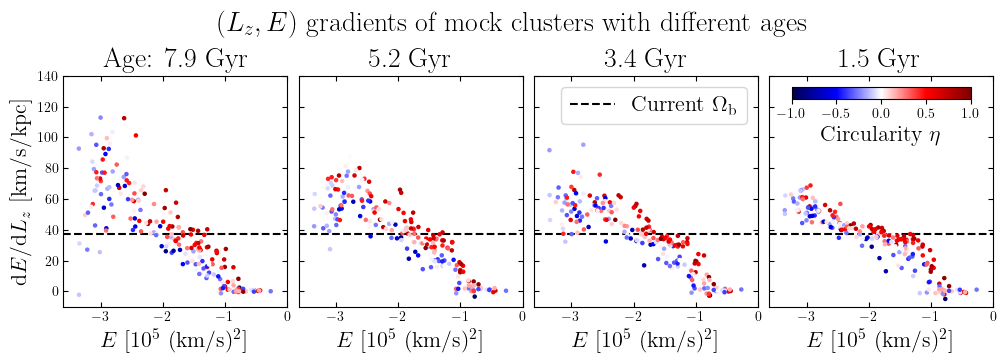

In [ ]:
'''Plot E/Lz slope of mock clusters at different ages'''

from scipy.stats import linregress
from matplotlib import cm

# slope = np.zeros(Nbody)
# # slope_slow = np.zeros(len(trajs_axi_array))

# for j in range(Nbody):
#     cut_plot = cut_blob[-1,j] * strip_flag[5,j] 

#     x = Lz[-1,cut_plot]
#     y = E[-1,cut_plot]

#     slope[j] = linregress(x, y)[0]

rgrid = np.linspace(0.1, 40, 1000)
vcirc = (-rgrid * pot_agama[-1].force(np.array([rgrid, 0*rgrid, 0*rgrid]).T)[:,0])**0.5
Lz_grid = rgrid * vcirc
E_circ = 0.5 * vcirc**2 + pot_agama[-1].potential(np.array([rgrid, 0*rgrid, 0*rgrid]).T)

Lz_circ = np.interp(E[-1,index_prog_array], E_circ, Lz_grid)

eta = Lz[-1,index_prog_array] / Lz_circ

norm = mcolors.Normalize(vmin=-1, vmax=1)#mcolors.LogNorm(vmin=1e-2, vmax=1e2)
cmap = cm.seismic
# colors = cmap(norm(values))

fig, axs = plt.subplots(1,4, figsize=(12,3), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05)

cax = axs[-1].inset_axes([0.1, 0.9, 0.8, 0.05])

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cb = plt.colorbar(sm, cax=cax, orientation='horizontal')
cb.set_label('Circularity $\eta$', fontsize=16)

for i in range(len(snap_plot_indices)-1):
    slope = np.zeros(Nbody)

    for j in range(Nbody):
        cut_plot = cut_blob[-1,j] * strip_flag[snap_plot_indices[i],j] 

        x = Lz[-1,cut_plot]
        y = E[-1,cut_plot]

        slope[j] = linregress(x, y)[0]

    axs[i].scatter(E[-1,index_prog_array]/1e5, slope, s=5, c=eta, cmap=cmap, norm=norm)

    if i == 0:
        axs[i].set_title('Age: '+str(np.round(tL_array[snap_plot_indices[i]],1))+' Gyr', fontsize=20)
    
    else:
        axs[i].set_title(str(np.round(tL_array[snap_plot_indices[i]],1))+' Gyr', fontsize=20)

for ax in axs.flat:
    ax.set_xlim(-3.6, 0)
    ax.set_ylim(-10, 140)
    
    ax.set_xlabel('$E$ [$10^5$ (km/s)$^2$]', fontsize=16)
    ax.axhline(Omegab_array[-1], ls='--', c='k', label='Current $\Omega_\mathrm{b}$', zorder=0)
    # ax.axhline(np.max(Omegab_array), ls='--', c='tab:red', label='Maximum $\Omega_\mathrm{b}$', zorder=0)
    ax.tick_params(top=True, bottom=True, right=True, left=True, direction='in')

    ax.set_rasterization_zorder(10)

axs[0].set_ylabel('$\mathrm{d}E/\mathrm{d}L_z$ [km/s/kpc]', fontsize=16)

axs[-2].legend(loc='upper right', fontsize=16)

fig.suptitle('$(L_z,E)$ gradients of mock clusters with different ages', fontsize=20, y=1.1)

plt.savefig(figpath+'auriga_gradients.pdf', bbox_inches='tight', dpi=200)
plt.show()
plt.close()

<>:24: SyntaxWarning: invalid escape sequence '\m'
<>:24: SyntaxWarning: invalid escape sequence '\m'
/var/folders/z0/1zblnsv52b3_xm5q_770smk40000gn/T/ipykernel_69053/3778400556.py:24: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel('$H_\mathrm{J}$ [$10^5$ (km/s)$^2$]', fontsize=16)


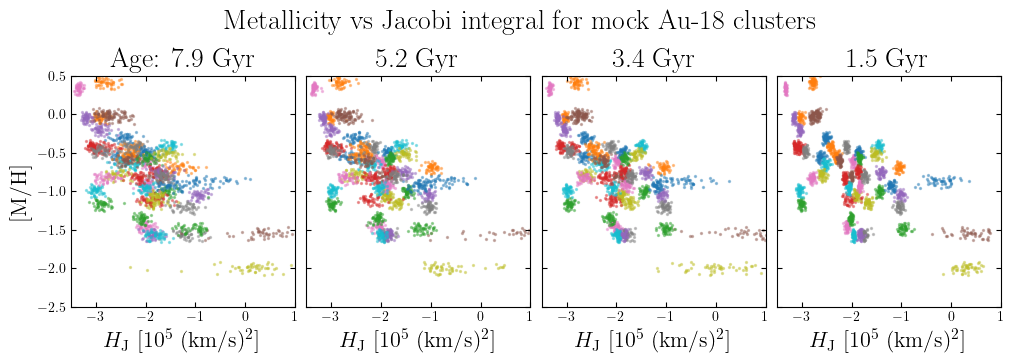

In [ ]:
'''Plot mock clusters in [M/H]/H_J space'''

fig, axs = plt.subplots(1,4, figsize=(12,3), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05)

Delta_MH = np.random.normal(0, 0.04, 50)

for j in range(Nplot):
    for i in range(len(snap_plot_indices)-1):
        cut_plot = cut_blob[-1,j] * strip_flag[snap_plot_indices[i],j]
        axs[i].scatter(HJ[-1,cut_plot]/1e5, MH[index_prog_array[j]]+Delta_MH, s=2, alpha=0.4, c=colors[j%10])
            

for i in range(len(snap_plot_indices)-1):
    
    if i == 0:
        axs[i].set_title('Age: '+str(np.round(tL_array[snap_plot_indices[i]],1))+' Gyr', fontsize=20)
    
    else:
        axs[i].set_title(str(np.round(tL_array[snap_plot_indices[i]],1))+' Gyr', fontsize=20)

for ax in axs.flat:
    ax.set_xlim(-3.5, 1)
    ax.set_ylim(-2.5, 0.5)
    
    ax.set_xlabel('$H_\mathrm{J}$ [$10^5$ (km/s)$^2$]', fontsize=16)
    # ax.set_xlabel('$E$ [$10^5$ (km/s)$^2$]', fontsize=16)
    # ax.axhline(Omegab_array[-1], ls='--', c='k', label='Current $\Omega_\mathrm{b}$', zorder=0)
    # ax.axhline(np.max(Omegab_array), ls='--', c='tab:red', label='Maximum $\Omega_\mathrm{b}$', zorder=0)
    ax.tick_params(top=True, bottom=True, right=True, left=True, direction='in')

    ax.set_rasterization_zorder(10)

axs[0].set_ylabel('[M/H]', fontsize=16)

fig.suptitle('Metallicity vs Jacobi integral for mock Au-18 clusters', fontsize=20, y=1.1)

plt.savefig(figpath+'auriga_MH_HJ.pdf', bbox_inches='tight', dpi=200)
plt.show()
plt.close()